In [1]:
import os, sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
mkl.set_num_threads(10)
import seaborn as sns
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our |plotting is done with plt
from src import utils # this is our own library of functions
from sklearn.metrics import accuracy_score
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython
#sys.path.insert(0, '/home/mano/Documents/Profesional Projects/Suite2p/suite2p/') #linux import
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [60]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_09', '1')
exp_db

[{'mname': 'TX80', 'datexp': '2022_06_17', 'blk': '1'},
 {'mname': 'TX80', 'datexp': '2022_06_09', 'blk': '1'}]

In [134]:
iexp       = 0
dual_plane = True
timeline   = utils.load_exp_info(exp_db[iexp])
spks, xpos, ypos, iplane, stat = utils.load_neurons(exp_db[iexp], dual_plane=True,baseline=True)

(20,)
plane 0,  neurons: 1098
plane 1,  neurons: 4180
plane 2,  neurons: 5125
plane 3,  neurons: 4101
plane 4,  neurons: 2319
plane 5,  neurons: 2326
plane 6,  neurons: 5271
plane 7,  neurons: 4153
plane 8,  neurons: 4344
plane 9,  neurons: 2990
plane 10,  neurons: 684
plane 11,  neurons: 2519
plane 12,  neurons: 2965
plane 13,  neurons: 2655
plane 14,  neurons: 1535
plane 15,  neurons: 1882
plane 16,  neurons: 3598
plane 17,  neurons: 2869
plane 18,  neurons: 2918
plane 19,  neurons: 1649
total neurons 59181


# Plot neuron positions

Text(0, 0.5, 'Y position (um)')

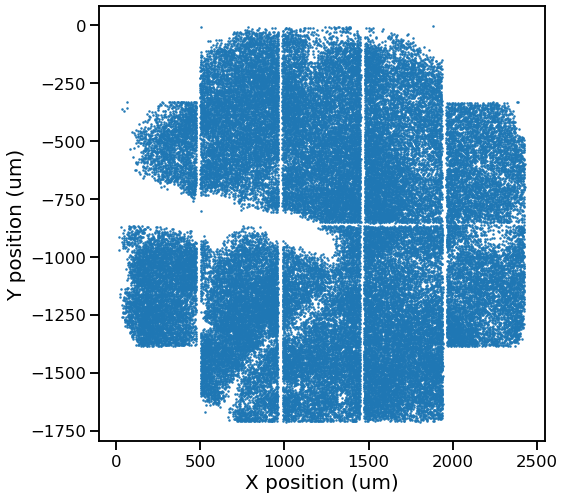

In [135]:
plt.figure(figsize=(8,8))
plt.scatter(xpos, -ypos, s = 1)
plt.xlabel('X position (um)', fontsize=20)
plt.ylabel('Y position (um)', fontsize=20)

In [136]:
neurons_atframes, subset_stim = utils.get_neurons_atframes(timeline,spks)

In [137]:
avg_response, csig = utils.get_tuned_neurons(neurons_atframes, subset_stim)

In [138]:
csig.mean()


0.100595206

# Visualize tuned neurons

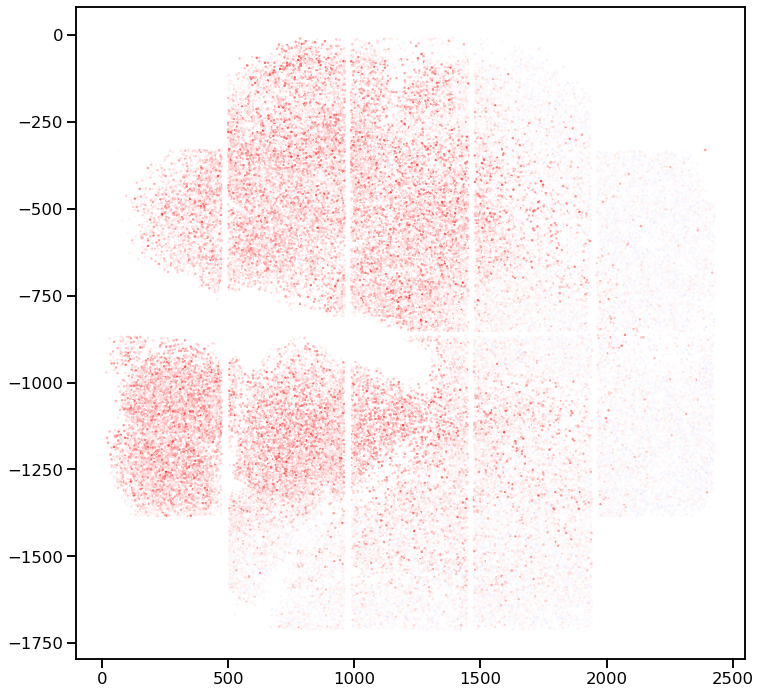

In [139]:
plt.figure(figsize=(12,12))
plt.scatter(xpos, -ypos, c = csig, cmap = 'bwr', vmax = 1, vmin=-1, s = 1)

# Get 8x4 stimuli for the Dprime decoder
* in the session 'TX80', '2022_06_17', '1' we used a combined stimuli from nat30k and textures 8x4, this block of code retrieve only the 8x4 repeats

In [248]:
cats, stim_idx = utils.get_stim_class_and_samples_ix(subset_stim, n_categories=8, samples_per_cat=4)

8 categories, 32 exemplars, 98 repeats


In [221]:
train_category = 0  # always even, since the even categories are the postive texture (rewarded) for each pair 
train_texture = 0 
samples_per_cat = 4

In [145]:
stim_idx.shape # exemplars, repeats

(32, 98)

In [249]:
neurons_at_first_two_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=0, exemplars_to_take=8)
neurons_at_first_two_cats.shape

(8, 59181, 98)

In [223]:
decoder_stimuli = np.zeros((8, neurons_atframes.shape[0], stim_idx.shape[1]))
train_idx = train_category * samples_per_cat
for exemplar in range(8):
    decoder_stimuli[exemplar] = neurons_atframes[:, stim_idx[train_idx+exemplar]]
X_train = decoder_stimuli[:, :, ::2] #Even repeats for training
X_test = decoder_stimuli[:, :, 1::2] #Odd repeats for testing
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (8, 59181, 49)
X_test shape: (8, 59181, 49)


In [157]:
categories_dict = {
    "0":"leaves",
    "1":"circles",
    "2":"dryland",
    "3":"rocks",
    "4":"tiles",
    "5":"squares",
    "6":"round leaves",
    "7":"paved"}

# Dprime calculation 
* this a block by block calculation of the last section, basically we use the category pair leaves/circles, training with the exemplar pair 0

In [264]:
from src.utils import DprimeDecoder
decoder = DprimeDecoder(samples_per_category=4, train_exemplar=0, threshold=0.5, decisionrule="optimal")
decoder.fit(X_train,iplane,zstack=2)
spop = decoder.test(X_test, iplane, zstack=2)

In [265]:

ix1 = (decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)  # the last ten ROIs are in the top plane
ix2 = (-decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)
# spop is the decoder applied to test trials
spop_train = X_train[:, ix1, :].mean(1) - X_train[:, ix2, :].mean(1)

In [226]:
spop_train[decoder.train_exemplar,:]

array([0.05758793, 0.07989336, 0.04145061, 0.08585932, 0.06745649,
       0.06791143, 0.07059749, 0.08377348, 0.04497511, 0.06903556,
       0.07325559, 0.06757465, 0.08156776, 0.07392696, 0.0668206 ,
       0.03324232, 0.07778655, 0.06827813, 0.0450547 , 0.06589686,
       0.06188881, 0.05123456, 0.099345  , 0.09668689, 0.03908761,
       0.0483736 , 0.05397998, 0.05947641, 0.05987432, 0.0551343 ,
       0.06607646, 0.05063806, 0.06314021, 0.05769653, 0.07194262,
       0.06055635, 0.03937116, 0.05111289, 0.04336891, 0.0546866 ,
       0.04940118, 0.05333603, 0.07804884, 0.0394348 , 0.05166794,
       0.004031  , 0.01997114, 0.01487399, 0.01308377])

In [266]:
spop_train = np.concatenate((spop_train[decoder.train_exemplar,:],spop_train[decoder.train_exemplar+decoder.samples_per_category,:]))
spop_train.shape

(98,)

In [267]:
y= np.concatenate((np.ones(int(spop_train.shape[0]/2)),np.zeros(int(spop_train.shape[0]/2))))
y.shape

(98,)

find the treshold:

In [268]:
spop_train = spop_train.reshape(-1,1)
train_min = spop_train.min()
train_max = spop_train.max()
threshold = np.arange(train_min,train_max,0.0001)
trsh = []
scre = []
for t in threshold:
    pred = spop_train>t
    acc = accuracy_score(y,pred) * 100
    trsh.append(t)
    scre.append(acc)
trsh = np.array(trsh)
scre = np.array(scre)
amax = np.argmax(scre)
trsh[amax]

-0.011437929682695636

In [269]:
spop_train = spop_train.reshape(2,-1)
trsh2 = ((spop_train[0]+spop_train[1])/2).mean()
trsh2

-0.0065987719342349704

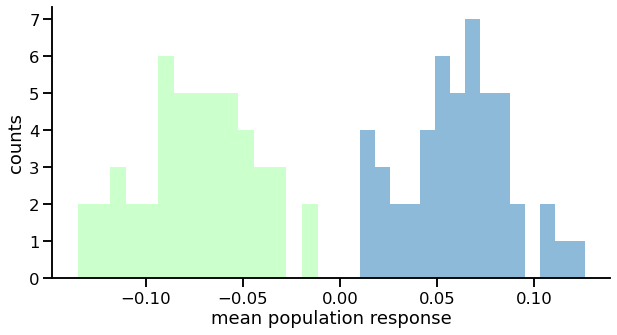

In [274]:
spop_train = spop_train.reshape(2,-1)
plt.figure(figsize=(10,5))
plt.hist(spop_train[0],bins=15, alpha=0.5, label = "leaves" )
plt.hist(spop_train[1],bins=15, alpha=0.5, label = "circles", color = "#98FF98")
#plt.vlines(x=trsh[amax],ymin=0,ymax=10, color='g', label = 'optimal boundary', linestyle = "--") # svm tresh
# plt.vlines(x=trsh2,ymin=0,ymax=10, color='r', label = 'midpoint boundary', linestyle = "--") # svm tresh 
#plt.title('finding treshold on single trail on training set')
plt.ylabel("counts")
plt.xlabel("mean population response")
#plt.legend()
sns.despine()

3191 neurons above d-prime = 0.5 for train exemplar: 0 from category: leaves


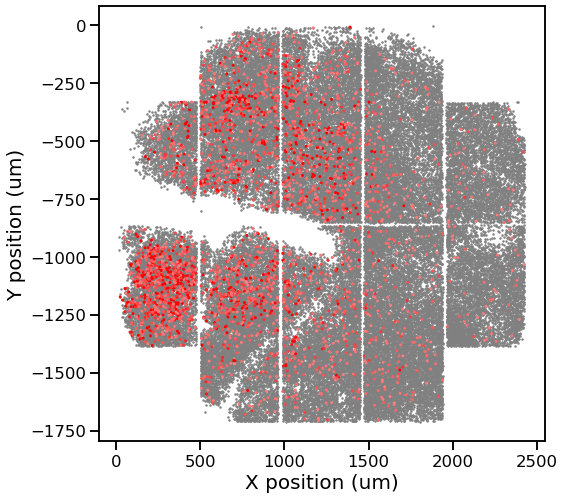

In [230]:
plt.figure(figsize=(8,8))
plt.scatter(xpos, -ypos, c = 'gray', s = 1)
plt.scatter(xpos[decoder.neurons_abvtresh_], -ypos[decoder.neurons_abvtresh_], c = decoder.dprime_[0,decoder.neurons_abvtresh_], cmap = 'bwr', vmax = 1, vmin=-1, s = 2);
print(f'{decoder.neurons_abvtresh_.sum()} neurons above d-prime = 0.5 for train exemplar: {train_category} from category: {categories_dict[str(train_category)]}')
plt.xlabel('X position (um)', fontsize=20);
plt.ylabel('Y position (um)', fontsize=20);

In [243]:
spop_test.mean(-1).reshape(-1,1).shape[0]/2

4.0

In [238]:
s = spop_test.reshape(2,-1)
y = np.ones(s.shape[1])
accuracy_score(y, s[0]>s[1]) * 100

97.44897959183673

In [234]:
s[0]>s[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [174]:
ix1 = (decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)  # the last ten ROIs are in the top plane
ix2 = (-decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)
# spop is the decoder applied to test trials
spop_test = X_test[:, ix1, :].mean(1) - X_test[:, ix2, :].mean(1)
pred = np.mean(spop_test, -1) > trsh[amax]
y = np.concatenate((np.ones(samples_per_cat), np.zeros(samples_per_cat)))
scr = accuracy_score(y, pred) * 100
scr

100.0

# doing it again but for all category pairs, and each training texture pair:
* Use even repeats (X_train) to fit the decoder, and find the optimal classification boundary
* Use the boundary to classify the repeat average of the odd trials (`np.mean(self.spop_, -1) > self.clf_boundary_`)

In [206]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="optimal")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 100.0
 category: leaves, exemplar trained: 1, accuracy: 100.0
 category: leaves, exemplar trained: 2, accuracy: 75.0
 category: leaves, exemplar trained: 3, accuracy: 87.5
 category: dryland, exemplar trained: 0, accuracy: 75.0
 category: dryland, exemplar trained: 1, accuracy: 62.5
 category: dryland, exemplar trained: 2, accuracy: 75.0
 category: dryland, exemplar trained: 3, accuracy: 62.5
 category: tiles, exemplar trained: 0, accuracy: 87.5
 category: tiles, exemplar trained: 1, accuracy: 62.5
 category: tiles, exemplar trained: 2, accuracy: 75.0
 category: tiles, exemplar trained: 3, accuracy: 75.0
 category: round leaves, exemplar trained: 0, accuracy: 87.5
 category: round leaves, exemplar trained: 1, accuracy: 62.5
 category: round leaves, exemplar trained: 2, accuracy: 100.0
 category: round leaves, exemplar trained: 3, accuracy: 100.0
############### OVERALL MEAN #####################
 category: leaves/circles, average accura

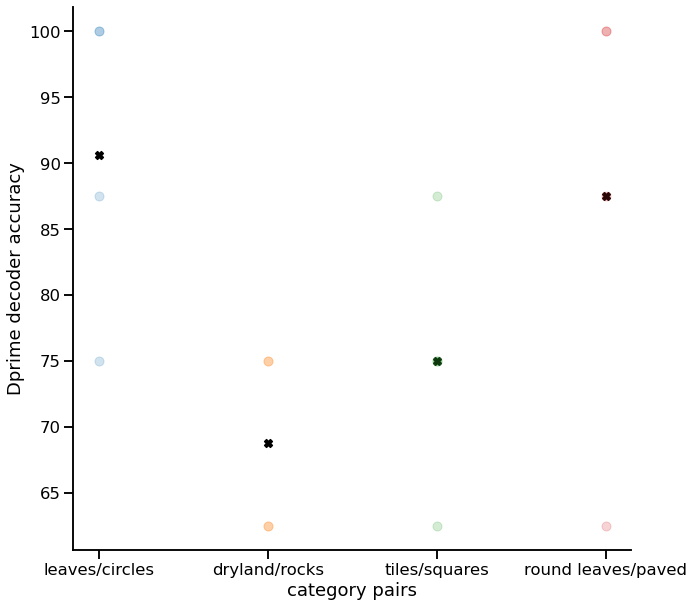

In [207]:
import seaborn as sns
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.plot(x,y, "o", alpha = 0.2)
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60)
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"])
plt.xlabel("category pairs");
sns.despine()

# Without averaging over the trials!!

In [208]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="optimal")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = False)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 93.62244897959184
 category: leaves, exemplar trained: 1, accuracy: 91.07142857142857
 category: leaves, exemplar trained: 2, accuracy: 79.08163265306123
 category: leaves, exemplar trained: 3, accuracy: 87.24489795918367
 category: dryland, exemplar trained: 0, accuracy: 72.70408163265306
 category: dryland, exemplar trained: 1, accuracy: 53.57142857142857
 category: dryland, exemplar trained: 2, accuracy: 67.3469387755102
 category: dryland, exemplar trained: 3, accuracy: 61.98979591836735
 category: tiles, exemplar trained: 0, accuracy: 84.6938775510204
 category: tiles, exemplar trained: 1, accuracy: 67.60204081632652
 category: tiles, exemplar trained: 2, accuracy: 79.08163265306123
 category: tiles, exemplar trained: 3, accuracy: 75.51020408163265
 category: round leaves, exemplar trained: 0, accuracy: 81.63265306122449
 category: round leaves, exemplar trained: 1, accuracy: 65.81632653061224
 category: round leaves, exemplar trai

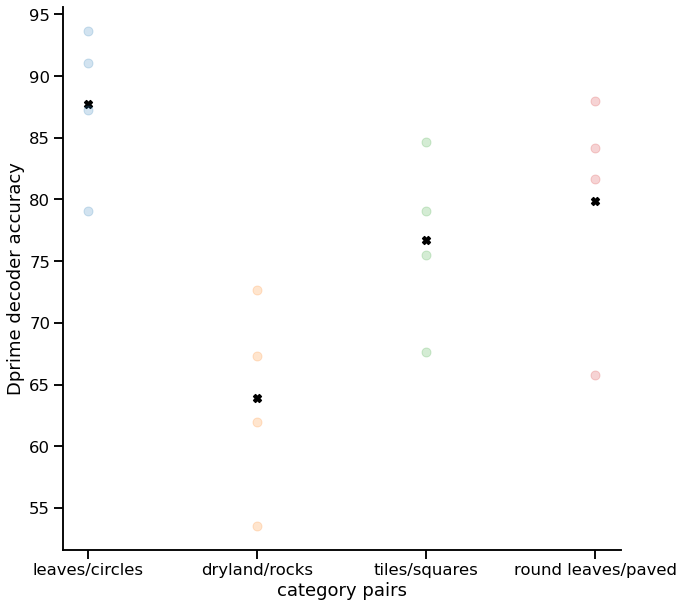

In [209]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.plot(x,y, "o", alpha = 0.2)
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60)
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"])
plt.xlabel("category pairs");
sns.despine()

# Midpoint rule
## averaging over test repeats

In [210]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 100.0
 category: leaves, exemplar trained: 1, accuracy: 87.5
 category: leaves, exemplar trained: 2, accuracy: 62.5
 category: leaves, exemplar trained: 3, accuracy: 75.0
 category: dryland, exemplar trained: 0, accuracy: 75.0
 category: dryland, exemplar trained: 1, accuracy: 37.5
 category: dryland, exemplar trained: 2, accuracy: 75.0
 category: dryland, exemplar trained: 3, accuracy: 62.5
 category: tiles, exemplar trained: 0, accuracy: 100.0
 category: tiles, exemplar trained: 1, accuracy: 100.0
 category: tiles, exemplar trained: 2, accuracy: 87.5
 category: tiles, exemplar trained: 3, accuracy: 100.0
 category: round leaves, exemplar trained: 0, accuracy: 62.5
 category: round leaves, exemplar trained: 1, accuracy: 87.5
 category: round leaves, exemplar trained: 2, accuracy: 75.0
 category: round leaves, exemplar trained: 3, accuracy: 87.5
############### OVERALL MEAN #####################
 category: leaves/circles, average accura

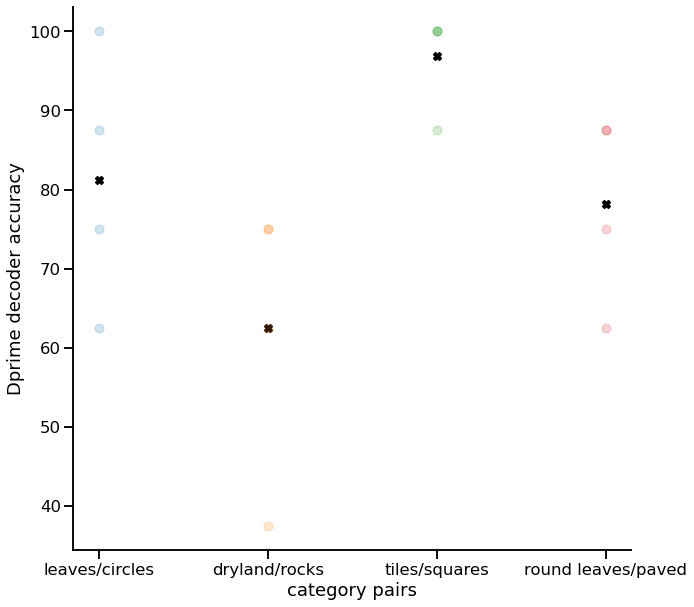

In [211]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.plot(x,y, "o", alpha = 0.2)
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60)
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"])
plt.xlabel("category pairs");
sns.despine()

## without averaging

In [212]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = False)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 92.85714285714286
 category: leaves, exemplar trained: 1, accuracy: 90.3061224489796
 category: leaves, exemplar trained: 2, accuracy: 63.52040816326531
 category: leaves, exemplar trained: 3, accuracy: 77.55102040816327
 category: dryland, exemplar trained: 0, accuracy: 73.21428571428571
 category: dryland, exemplar trained: 1, accuracy: 46.42857142857143
 category: dryland, exemplar trained: 2, accuracy: 73.46938775510205
 category: dryland, exemplar trained: 3, accuracy: 61.98979591836735
 category: tiles, exemplar trained: 0, accuracy: 88.5204081632653
 category: tiles, exemplar trained: 1, accuracy: 80.10204081632652
 category: tiles, exemplar trained: 2, accuracy: 85.45918367346938
 category: tiles, exemplar trained: 3, accuracy: 90.05102040816327
 category: round leaves, exemplar trained: 0, accuracy: 73.9795918367347
 category: round leaves, exemplar trained: 1, accuracy: 89.03061224489795
 category: round leaves, exemplar train

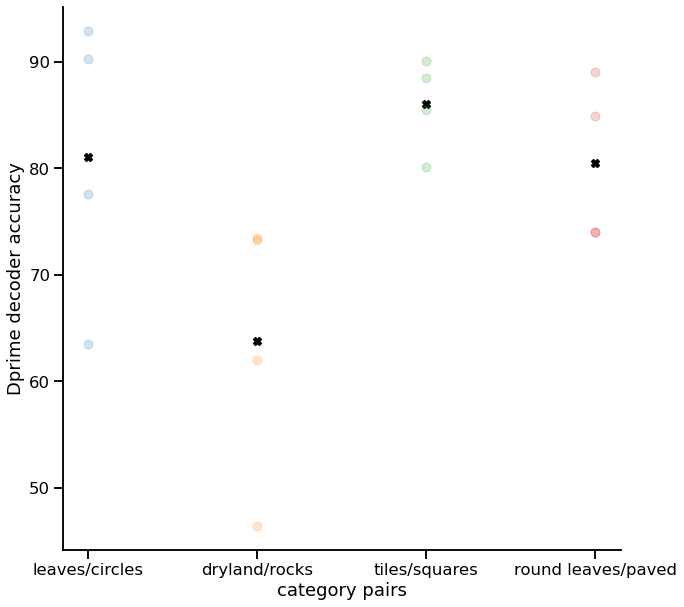

In [213]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.plot(x,y, "o", alpha = 0.2)
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60)
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"])
plt.xlabel("category pairs");
sns.despine()

# AFC averaging 

In [297]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = True, AFC = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 100.0
 category: leaves, exemplar trained: 1, accuracy: 100.0
 category: leaves, exemplar trained: 2, accuracy: 100.0
 category: leaves, exemplar trained: 3, accuracy: 100.0
 category: dryland, exemplar trained: 0, accuracy: 75.0
 category: dryland, exemplar trained: 1, accuracy: 25.0
 category: dryland, exemplar trained: 2, accuracy: 75.0
 category: dryland, exemplar trained: 3, accuracy: 75.0
 category: tiles, exemplar trained: 0, accuracy: 100.0
 category: tiles, exemplar trained: 1, accuracy: 100.0
 category: tiles, exemplar trained: 2, accuracy: 100.0
 category: tiles, exemplar trained: 3, accuracy: 100.0
 category: round leaves, exemplar trained: 0, accuracy: 75.0
 category: round leaves, exemplar trained: 1, accuracy: 100.0
 category: round leaves, exemplar trained: 2, accuracy: 100.0
 category: round leaves, exemplar trained: 3, accuracy: 100.0
############### OVERALL MEAN #####################
 category: leaves/circles, average

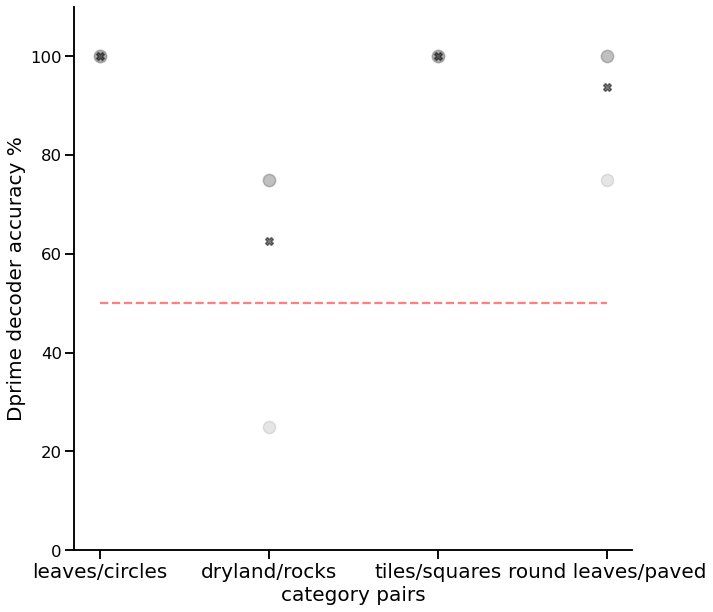

In [299]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.scatter(x,y, alpha = 0.2 , s = 150, color= "gray")
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60, alpha = 0.5)
plt.ylabel("Dprime decoder accuracy %", size = 20)
plt.hlines(y=50,xmin=0,xmax=3, linestyles="--", color = "red", alpha = 0.5)
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"], size = 20)
plt.xlabel("category pairs", size = 20);
plt.ylim(0,110)
sns.despine()
plt.savefig("acc_test", dpi=300)

In [300]:
train_category = np.arange(0,len(cats),2)  #even category is the start of a new pair
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        neurons_at_cats = utils.select_neurons_by_stimsubset(neurons_atframes, stim_idx, cats, category_tostart=category, exemplars_to_take=8)
        X_train = neurons_at_cats[:, :, ::2] #Even repeats for training
        X_test = neurons_at_cats[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=4, train_exemplar=texture, threshold=0.5, decisionrule="midpoint")
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score(avg_test_reps = False, AFC = True)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)
print('############### OVERALL MEAN #####################')
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves, exemplar trained: 0, accuracy: 97.44897959183673
 category: leaves, exemplar trained: 1, accuracy: 99.48979591836735
 category: leaves, exemplar trained: 2, accuracy: 96.42857142857143
 category: leaves, exemplar trained: 3, accuracy: 98.46938775510205
 category: dryland, exemplar trained: 0, accuracy: 64.28571428571429
 category: dryland, exemplar trained: 1, accuracy: 42.3469387755102
 category: dryland, exemplar trained: 2, accuracy: 75.51020408163265
 category: dryland, exemplar trained: 3, accuracy: 64.28571428571429
 category: tiles, exemplar trained: 0, accuracy: 92.85714285714286
 category: tiles, exemplar trained: 1, accuracy: 89.79591836734694
 category: tiles, exemplar trained: 2, accuracy: 93.87755102040816
 category: tiles, exemplar trained: 3, accuracy: 95.40816326530613
 category: round leaves, exemplar trained: 0, accuracy: 84.6938775510204
 category: round leaves, exemplar trained: 1, accuracy: 94.89795918367348
 category: round leaves, exemplar trai

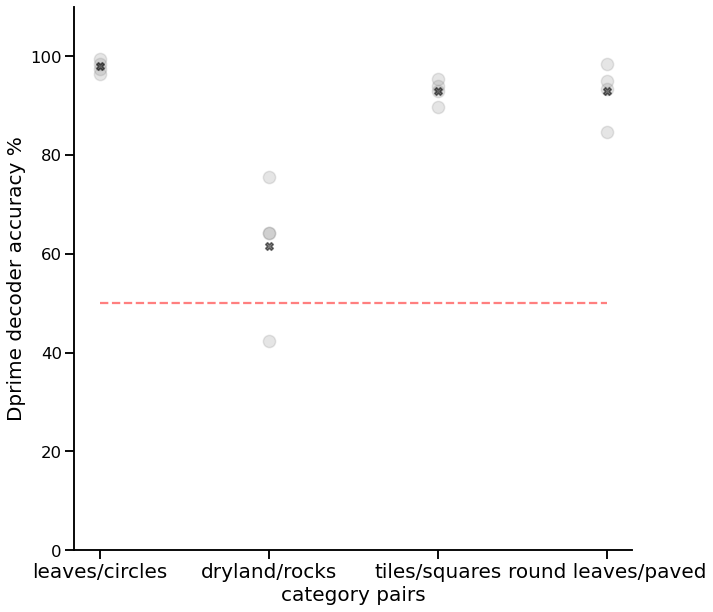

In [301]:
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.scatter(x,y, alpha = 0.2 , s = 150, color= "gray")
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60, alpha = 0.5)
plt.ylabel("Dprime decoder accuracy %", size = 20)
plt.hlines(y=50,xmin=0,xmax=3, linestyles="--", color = "red", alpha = 0.5)
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"], size = 20)
plt.xlabel("category pairs", size = 20);
plt.ylim(0,110)
sns.despine()
plt.savefig("acc_noavg", dpi=300)